In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from jax.scipy.optimize import minimize 
from LombScargle import periodogram, psd
from hypothesis_testing.bayes_factor import logB
from quasars import prep

from simulations.util import  *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
data = pd.read_csv('data/real.csv')
data2 = pd.read_csv('data/real_randomized.csv')
data = data.sort_values('log_lik_ratio', ascending= False)[:10].reindex()
data = data[data['cycles'] > 5]
display(data)
data.index[0]

,logB,log_lik_ratio,white_periodogram,cycles,period,sigma,tau,A_const,A_sin,A_cos,id,data_points
33991,349.462131,424.894507,72131.796886,21.952523,63.639800,0.431655,12.281851,18.957233,0.022792,0.399546,370319,73
6048,NaN,325.129755,232.812773,13.281418,108.275064,0.139081,577.320787,19.046025,-0.008042,0.005157,302516,294
22152,NaN,140.951438,6773.629401,8.210370,175.156326,0.187963,2.928154,17.852944,-0.028148,0.018567,232125,194
34767,NaN,78.177643,36.671185,9.293179,144.629339,0.147026,0.693516,19.878436,-0.020160,0.023388,264144,266
17844,35.096656,68.133233,1824.178540,22.672310,61.312783,0.301860,13.857126,20.719732,0.250306,-0.285145,257014,49
23916,NaN,66.778690,18.818619,23.262547,62.204313,0.109377,0.760812,20.351068,-0.015274,0.022965,297798,399


33991

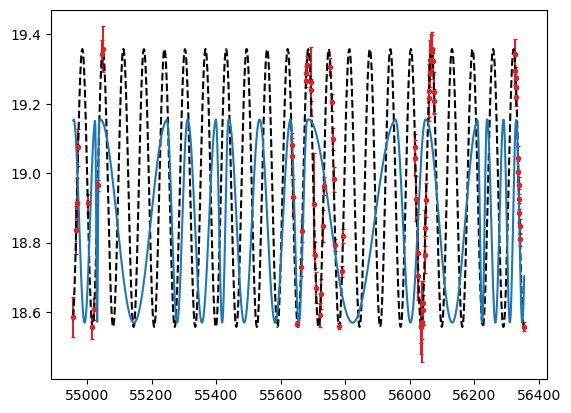

89.323715 63.991333


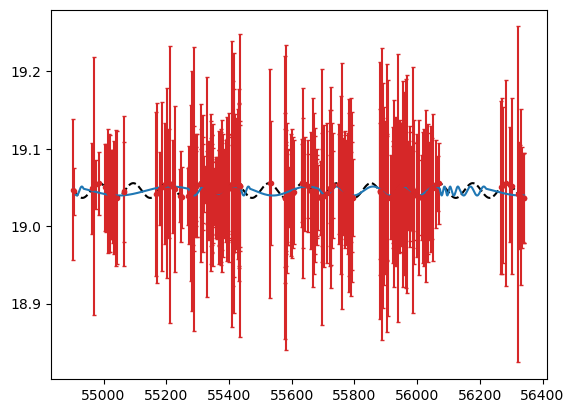

1.8292809 1.0917958


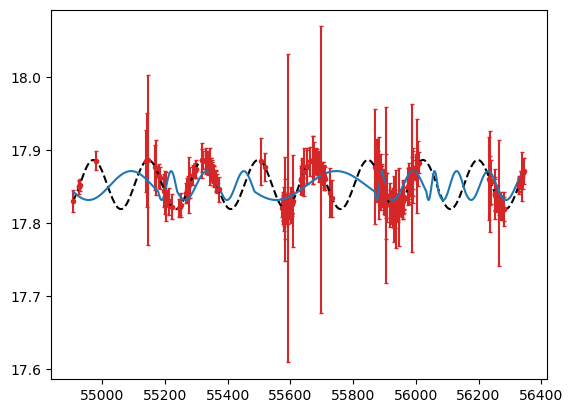

17.74814 11.459013


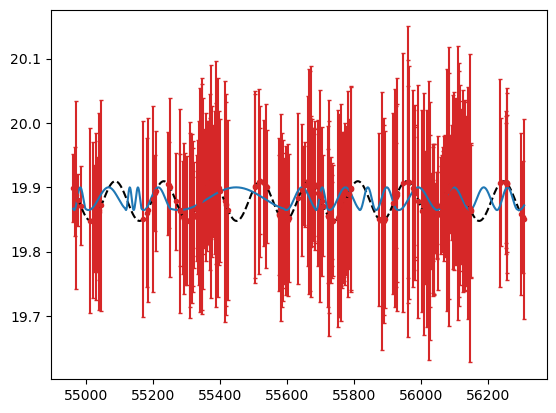

3.812223 2.0734036


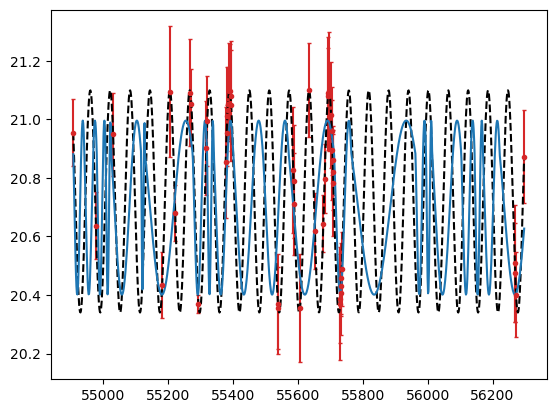

16.318174 13.946377


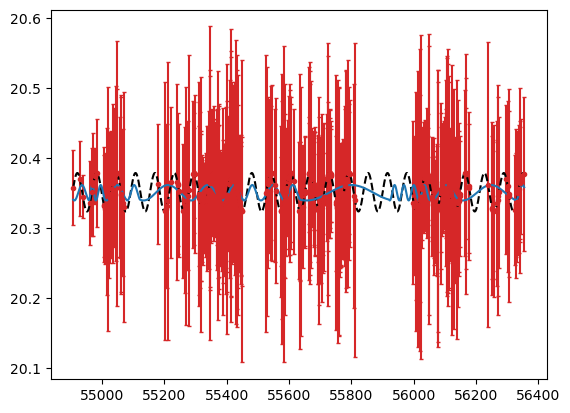

4.616864 1.8511769
[0.716398   0.59684426 0.64564586 0.5438831  0.854653   0.4009598 ]


In [3]:
from quasars.prep import ids

num_quasars = 35383
keys = jax.random.split(jax.random.PRNGKey(42), num_quasars)


def _reduction(time, mag_err, freq, period, a, temp_func):
    freq_injected = 1./period
    signal = periodogram.fit(time, freq_injected, a)

    # score with the original template
    score0, _ = periodogram.lomb_scargle(time, signal, True, mag_err)(freq_injected)
    
    # score with the modified template
    score, amps = jax.vmap(periodogram.lomb_scargle(time, signal, True, mag_err, temp_func= temp_func))(freq)
    ind = jnp.argmax(score)
    plt.errorbar(time, signal, mag_err, fmt= '.', capsize= 1.5, color = 'tab:red')
    t = jnp.linspace(jnp.min(time), jnp.max(time), 1000)
    plt.plot(t, periodogram.fit(t, freq_injected, a), '--', color = 'black')
    plt.plot(t, periodogram.fit(t, freq[ind], amps[ind], temp_func), color = 'tab:blue')
    plt.show()
    score1 = jnp.max(score)
    print(np.sqrt(score0), np.sqrt(score1))
    return [score0, score1]


def get_key(id):
    simulation_id = ids.tolist().index(id) # find the simulation id with the given quasar id
    return jax.random.split(keys[simulation_id], 3)[2] # mock the key splitting in the original search
    

def reduction(myid):
    ind = data.index[myid]
    id, period, a0, a1, a2 = data.loc[ind, 'id'], data.loc[ind, 'period'], data.loc[ind, 'A_const'], data.loc[ind, 'A_sin'], data.loc[ind, 'A_cos']
    A = jnp.array([a0, a1, a2])
    
    time, _, mag_err, freq, _ = prep.prepare_data(id)
    key = get_key(id)
    return _reduction(time, mag_err, freq, period, A, temp(key))


temp = lambda key: periodogram.randomized_period(key, 2000, 2.)
r = np.sqrt(np.array([reduction(myid) for myid in range(len(data))]))
print(r[:, 1] / r[:, 0])

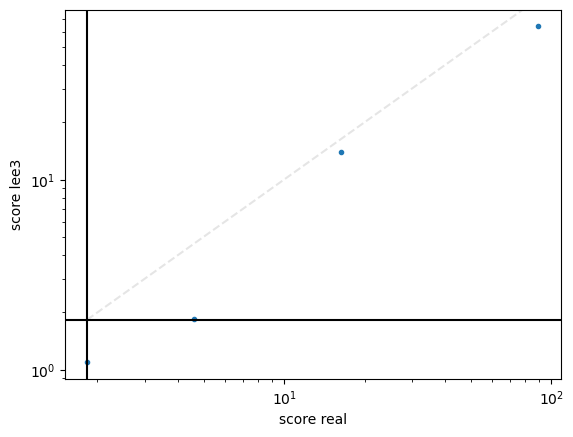

In [18]:
# plt.plot(r[:, 0], r[:, 1], '.')
# score_cut = np.min(r[:, 0])

# plt.yscale('log')
# plt.xscale('log')
# xlim, ylim = plt.gca().get_xlim(), plt.gca().get_ylim()
# cut = np.ones(2) * score_cut
# minmax = [np.min(r[:, 0]), np.max(r[:, 0])]
# plt.plot(cut, ylim, '-', color = 'black')
# plt.plot(xlim, cut, '-', color = 'black')
# plt.plot(minmax, minmax, '--', color = 'black', alpha = 0.1)
# plt.xlabel('score real')
# plt.ylabel('score lee3')
# plt.xlim(*xlim)
# plt.ylim(*ylim)
# plt.show()